In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 
import gzip

from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits
from nxontology import NXOntology

#!pip install pandas-profiling[notebook]==2.10.1
from pandas_profiling import ProfileReport

#from ontoma import OnToma
#otmap = OnToma()

import seaborn as sns

# Apply the default theme
sns.set_theme()

In [2]:
# globals
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
#efo_data = 'data/efo_data.txt.gz'
efo_nodes = 'data/epigraphdb_efo_nodes.csv'
efo_rels = 'data/epigraphdb_efo_rels.csv'
nxontology_measure = 'batet'

modelData = [
    {'name':'BioSentVec','model':'BioSentVec'},
    {'name':'BioBERT','model':'biobert_v1.1_pubmed'},
    {'name':'BlueBERT','model':'NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12'},
]

pallete="hls"

In [3]:
# get the EBI UKB data
#get ebi data
#url='https://raw.githubusercontent.com/EBISPOT/EFO-UKB-mappings/master/UK_Biobank_master_file.tsv'
#ebi_df = pd.read_csv(url,sep='\t')

ebi_df = pd.read_csv(ebi_data,sep='\t')

#drop some columns
ebi_df = ebi_df[['ZOOMA QUERY','MAPPED_TERM_LABEL','MAPPED_TERM_URI']]
ebi_df.rename(columns={'ZOOMA QUERY':'query'},inplace=True)
print(ebi_df.head())
print(ebi_df.shape)

#create new rows for multiple labels
#ebi_df = (
#        ebi_df.assign(label=ebi_df.MAPPED_TERM_LABEL.str.split("\|\|"))
#        .explode("label")
#        .reset_index(drop=True).drop('MAPPED_TERM_LABEL',axis=1)
#    )

#create new rows for multiple ids
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|\|',',')
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|',',')
ebi_df = (
        ebi_df.assign(id=ebi_df.MAPPED_TERM_URI.str.split(","))
        .explode("id")
        .reset_index(drop=True).drop('MAPPED_TERM_URI',axis=1)
    )

#clean up
ebi_df['id'] = ebi_df['id'].str.strip()

#drop cases where query and id are the same
ebi_df.drop_duplicates(subset=['query','id'],inplace=True)
print(ebi_df.shape)

#drop nan
ebi_df.dropna(inplace=True)
print(ebi_df.shape)
print(ebi_df.head())


                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            MAPPED_TERM_URI  
0  EFO_0004264, EFO_0009431  
1               EFO_0004616  
2               EFO_0003778  
3               EFO_0003901  
4               EFO_0004247  
(1565, 3)
(1613, 3)
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4       

In [4]:
%%time

# get EFO node data
efo_node_df = pd.read_csv(efo_nodes)
efo_node_df.rename(columns={'efo.value':'efo_label','efo.id':'efo_id'},inplace=True)
#drop type
efo_node_df.drop('efo.type',inplace=True,axis=1)
efo_node_df.drop_duplicates(inplace=True)
print(efo_node_df)

                                      efo_label  \
0                 Xeroderma pigmentosum variant   
1                         Xeroderma pigmentosum   
2                               Ischemic stroke   
3                             Cerebral ischemia   
4                          small cell carcinoma   
...                                         ...   
25385         Acetazolamide-responsive myotonia   
25386  Complete androgen insensitivity syndrome   
25387                Intermediate DEND syndrome   
25388                              Epiblepharon   
25389              Congenital eyelid retraction   

                                          efo_id  
0       http://www.orpha.net/ORDO/Orphanet_90342  
1         http://www.orpha.net/ORDO/Orphanet_910  
2      http://purl.obolibrary.org/obo/HP_0002140  
3      http://purl.obolibrary.org/obo/HP_0002637  
4           http://www.ebi.ac.uk/efo/EFO_0008524  
...                                          ...  
25385   http://www.orpha.net/O

In [5]:
#check all terms in EBI data set are in EFO node data
efo_node_ids = list(efo_node_df['efo_id'])
ebi_ids = list(ebi_df['id'])
missing=[]
matched = []
for i in ebi_ids:
    match = False
    for s in efo_node_ids:
        if i in s and match == False:
            matched.append(s)
            match = True
    if match == False:
        missing.append(i)
print('Missing:',len(missing))

# remove missing from ukb data
print(ebi_df.shape)
for i in missing:
    ebi_df = ebi_df.drop(ebi_df[ebi_df['id'].str.contains(i)].index)
ebi_df['full_id'] = matched
print(ebi_df.head())
print(ebi_df.shape)
ebi_df.to_csv('output/ebi-ukb-cleaned.tsv',index=False,sep='\t')


Missing: 21
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264  
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431  
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616  
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778  
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901  
(1579, 4)


In [6]:
# preprocess
process_text=[]
for k,g in ebi_df.groupby(np.arange(len(ebi_df))//20):
    params={'text_list':list(g['query'])}
    process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
    process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
print(len(process_text))
    
ebi_df.loc[:, 'processed'] = process_text
print(ebi_df.head())

1579
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431   
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   

                                  processed  
0           vascular disorders of intestine  
1           vascular disorders of intestine  
2                              gonarthrosis  
3  psoriatic and enteropathic arthropathies  
4

In [7]:
%%time

f='output/ebi-ukb-vec.tsv.gz'
if os.path.exists(f):
    print('Already done, reading',f)
    ebi_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    for m in modelData:
        ebi_df[m['name']] = ebi_df[m['name']].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    for m in modelData:    
        ebi_df = encode_traits(trait_df=ebi_df,col='processed',name=m['name'],model=m['model'])
    ebi_df.to_csv(f,sep='\t',compression='gzip',index=False)

print(ebi_df.head())
print(ebi_df.shape)

Already done, reading output/ebi-ukb-vec.tsv.gz
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431   
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   

                                  processed  \
0           vascular disorders of intestine   
1           vascular disorders of intestine   
2                              gonarthrosis   


In [8]:
%%time

# takes ~30 mins for each BERT based model

#test
#efo_node_df = efo_node_df.head(n=5000)

f='output/efo-vec.tsv.gz'
if os.path.exists(f):
    print('Already done, reading',f)
    efo_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    for m in modelData:
        efo_df[m['name']] = efo_df[m['name']].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    for m in modelData:    
        efo_df = encode_traits(trait_df=efo_node_df,col='efo_label',name=m['name'],model=m['model'])
    efo_df.to_csv(f,sep='\t',compression='gzip',index=False)    
print(efo_df.head())


Already done, reading output/efo-vec.tsv.gz
                       efo_label                                     efo_id  \
0  Xeroderma pigmentosum variant   http://www.orpha.net/ORDO/Orphanet_90342   
1          Xeroderma pigmentosum     http://www.orpha.net/ORDO/Orphanet_910   
2                Ischemic stroke  http://purl.obolibrary.org/obo/HP_0002140   
3              Cerebral ischemia  http://purl.obolibrary.org/obo/HP_0002637   
4           small cell carcinoma       http://www.ebi.ac.uk/efo/EFO_0008524   

                                          BioSentVec  \
0  [-0.045969586819410324, 0.5196870565414429, -0...   
1  [0.01842655800282955, 0.7100013494491577, -0.7...   
2  [0.5974032282829285, -0.6174705028533936, -0.1...   
3  [0.46593865752220154, -0.6334501504898071, 0.0...   
4  [0.4248107373714447, 0.033654093742370605, 0.3...   

                                             BioBERT  \
0  [-0.2842123508453369, 0.22479310631752014, 0.1...   
1  [-0.34557363390922546, 0.2918

In [9]:
#create nxontology network of EFO relationships
def create_efo_nxo() -> NXOntology:
    nxo = NXOntology()
    
    edges = []
    efo_rel_df=pd.read_csv(efo_rels)
    for i,row in efo_rel_df.iterrows():
        child = row['efo.id']
        parent = row['parent_efo.id']
        edges.append((parent,child))
    #print(edges[0:10])
    nxo.graph.add_edges_from(edges)
    return nxo

efo_nx = create_efo_nxo()
efo_nx.freeze()

In [22]:
%%time
def run_pairs(model):
    #ebi_df['BioSentVec']
    v1 = list(ebi_df[model])

    v2 = list(efo_df[model])
    # cosine of all against all
    dd = create_pair_distances(v1,v2)
    return dd

def write_to_file(model,pairwise_data):
    fo = gzip.open(f'output/{model}-pairwise.tsv','w')
    ebi_efo_list = ebi_df['full_id']
    efo_list = efo_df['efo_id']
    for i in range(0,len(ebi_efo_list)):
        # write to file
        mCount=0
        for j in range(i,len(efo_list)):
            if i != j:
                #print(ids[i],ids[j],1-pws[mCount])
                score = 1-pairwise_data[i][j]
                fo.write(f"{ebi_efo_list[i]}\t{efo_list[j]}\t{score}\n")
                mCount+=1
                
def get_top(model,pairwise_data):
    count=0
    dis_results=[]
    efo_map = []
    cosine_results = []
    manual_pos_results = []
    for manual_efo in ebi_df['full_id']:
        try:
            # find the EFO term with minumum distance
            min_dis = np.nanargmin(pairwise_data[count])
            min_val = np.nanmin(pairwise_data[count])

            predicted_efo = efo_df.iloc[min_dis]['efo_id']
            #efo_map.append(predicted_efo)

            # find the location of the 'correct' EFO term and get ordered position 
            manual_loc = efo_df[efo_df['efo_id'] == manual_efo].index[0]
            manual_dis = pairwise_data[count][manual_loc]
            #print(manual_dis)
            sorted_dis = sorted(pairwise_data[count],reverse=True)
            #print(sorted_dis)
            manual_dis_loc = sorted_dis.index(manual_dis)
            #print(manual_efo,manual_loc,manual_dis_loc)
            manual_pos_results.append(manual_dis_loc)
            
        except:
            min_dis=0
            min_val=0
            manual_pos_results.append(None)
        #print('EFO:',efo_df.iloc[min_dis][['name','id']].values,min_val)
        try:
            #run nxontology similarity
            res = similarity = efo_nx.similarity(manual_efo,efo_df.iloc[min_dis]['efo_id']).results()
            dis_results.append(res[nxontology_measure])
            
            efo_map.append(predicted_efo)
            cosine_results.append(1-min_val)

        except:
            #print('something wrong')
            exit()
        count+=1
    ebi_df[f'{model}-nx']=dis_results
    ebi_df[f'{model}-efo']=efo_map
    ebi_df[f'{model}-cosine']=cosine_results
    ebi_df[f'{model}-manual-pos']=manual_pos_results
    #print(ebi_df.head())
    print(model,'greater than 0.8:',ebi_df[ebi_df[f'{model}-nx']>0.8].shape)
    #plot histogram of distances
    sns_plot = sns.displot(ebi_df, x=f"{model}-nx",kde=True)
    sns_plot.savefig(f"output/{model}-{nxontology_measure}-nx.pdf")
    #plot correlation between cosine and nxontolgy
    sns_rel = sns.relplot(data=ebi_df, x=f'{model}-nx', y=f'{model}-cosine')
    sns_rel.savefig(f"output/{model}-nx-vs-cosine.pdf")
    #plot histogram of correct EFO location
    sns_plot = sns.displot(ebi_df, x=f"{model}-manual-pos",kde=True)
    sns_plot.savefig(f"output/{model}-manual-pos.pdf")

#dd = run_pairs('BioSentVec')
#get_top('BioSentVec',dd)
#for m in modelData:
#    dd = run_pairs(m['name'])
#    get_top(m['name'],dd)    

#print(ebi_df.head())

CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 20 µs
Parser   : 1.77 s


In [ ]:
#get_top('BioSentVec',dd)
for m in modelData:
    print(m['name'])
    dd = run_pairs(m['name'])
    get_top(m['name'],dd)    

print(ebi_df.head())

Creating distances...
1579 25390
1579


In [2]:
# ontoma 
#print(otmap.find_term('Vascular disorders of intestine'))
#think this is just using zooma

In [15]:
# zooma using web app
# ran the web app using filtered list of terms
# Configure Data Sources - Don't search in any datasources checked
# Configure Ontology Sources - EFO
# https://www.ebi.ac.uk/spot/zooma

#zooma_df = pd.read_csv('data/zooma.tsv',sep='\t')
#zooma_df['zooma_efo'] = zooma_df['ONTOLOGY(S)']+zooma_df['ONTOLOGY TERM(S)']
#zooma_df.drop_duplicates(subset=['zooma_efo'],inplace=True)
#print(zooma_df.shape)

In [16]:
# zooma using API
def run_zooma(text):
    zooma_api = 'https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate'
    payload = {
        'propertyValue':text,
        'filter':'required:[none],ontologies:[efo]'
    }
    res = requests.get(zooma_api,params=payload).json()
    if res:
        #print(text,res[0]['semanticTags'])
        return res[0]['semanticTags'][0]
    else:
        return 'NA'

In [19]:
%%time

# takes around 3 minutes for 1,000
f='output/ebi-zooma-api.tsv'
if os.path.exists(f):
    ebi_df_zooma = pd.read_csv(f,sep='\t')
else:
    ebi_df_zooma = ebi_df
    ebi_df_zooma['zooma_api'] = ebi_df_zooma['query'].apply(lambda x:run_zooma(x))
    ebi_df_zooma.to_csv('output/ebi-zooma-api.tsv',sep='\t',index=False)
print(ebi_df_zooma.head())
print(ebi_df_zooma.shape)

                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431   
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   

                                  processed  \
0           vascular disorders of intestine   
1           vascular disorders of intestine   
2                              gonarthrosis   
3  psoriatic and enteropathic arthropathies   
4

1579
(740, 18)


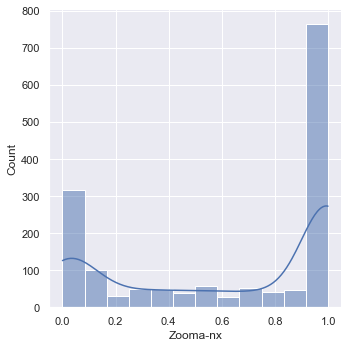

In [20]:
#print(zooma_df.head())

# merge with ebi file
#m = pd.merge(zooma_df,ebi_df,left_on='PROPERTY VALUE',right_on='query')
#m.drop_duplicates(inplace=True)
#print(m.head())
#print(m.shape)

dis_results=[]
for i, row in ebi_df_zooma.iterrows():
    try:
        res = similarity = efo_nx.similarity(row['zooma_api'],row['full_id']).results()
        dis_results.append(res[nxontology_measure])
    except:
        dis_results.append(0)
        
print(len(dis_results))
ebi_df['Zooma-nx'] = dis_results
print(ebi_df[ebi_df['Zooma-nx']>0.99].shape)
ebi_df.to_csv('output/ebi-nx.tsv',sep='\t',index=False)
sns.displot(ebi_df, x="Zooma-nx",kde=True)

In [21]:
# BERT-EFO

def bert_efo():
    bef_df = pd.read_csv('data/bluebert_efo_mapping.csv')
    bef_df.rename(columns={'efo_id':'BERT-EFO-efo-id'},inplace=True)
    print(bef_df.head())
    print(bef_df.shape)

    # merge with ebi_df
    ebi_df_merge = pd.merge(ebi_df,bef_df,left_on='query',right_on='ukbb_trait')
    print(ebi_df_merge.head())

    dis_results=[]
    name = 'BERT-EFO-nx'
    for i, row in ebi_df_merge.iterrows():
        try:
            res = similarity = efo_nx.similarity(row['BERT-EFO-efo-id'],row['full_id']).results()
            dis_results.append(res[nxontology_measure])
        except:
            dis_results.append(0)

    print(len(dis_results))
    ebi_df_merge[name] = dis_results
    print(ebi_df_merge.head())
    print(ebi_df_merge[ebi_df_merge['BERT-EFO-nx']>0.9].shape)
    ebi_df_merge.to_csv('output/ebi-nx.tsv',sep='\t',index=False)
    sns.displot(ebi_df_merge, x=name,kde=True)

In [ ]:
#print(ebi_df_merge[ebi_df_merge['BERT-EFO-nx']==0][['query','full_id','BERT-EFO-efo-id']])
#efo_nx.similarity('http://www.ebi.ac.uk/efo/EFO_0004143','http://www.ebi.ac.uk/efo/EFO_0009510').results()

In [22]:
# compare the methods
# which values does BioSentVec map but zooma does not?

#bb1 = ebi_df_merge[(ebi_df['BioSentVec-nx']==1) & (ebi_df_merge['Zooma-nx']<0.8)]
#print(bb1.shape)

#bb2 = ebi_df_merge[(ebi_df['Zooma-nx']==1) & (ebi_df_merge['BioSentVec-nx']<0.8)]
#print(bb2[['query','MAPPED_TERM_LABEL','full_id','BioSentVec-nx','BioSentVec-efo']])

NameError: name 'ebi_df_merge' is not defined

(1579, 18)


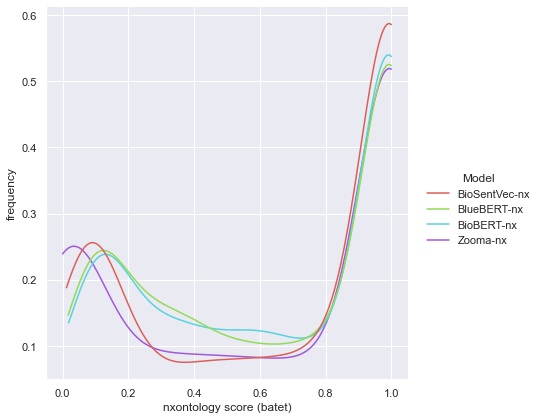

In [63]:
# melt data for plots
ebi_df_merge = ebi_df
#print(ebi_df_merge.head())

print(ebi_df_merge.shape)
#ebi_df_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=['BioSentVec-nx','BlueBERT-nx','BioBERT-nx','Zooma-nx','BERT-EFO-nx'])
ebi_df_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=['BioSentVec-nx','BlueBERT-nx','BioBERT-nx','Zooma-nx'])
ebi_df_melt.rename(columns={'variable':'Model'},inplace=True)
#print(ebi_df_melt.head())


# violin plot
#ax = sns.violinplot(x="variable", y="value", inner='quartile', data=ebi_df_melt, cut=0)
#ax.set_title('EFO distance', fontsize=16);
#fig = ax.get_figure()
#fig.savefig(f"output/all-nx.pdf")

ax = sns.displot(x="value", hue="Model", data=ebi_df_melt, kind="kde", cut=0, palette=pallete, height=6)
ax.set(xlabel=f'nxontology score ({nxontology_measure})', ylabel='frequency')
ax.savefig(f"output/all-nx-kde.pdf")

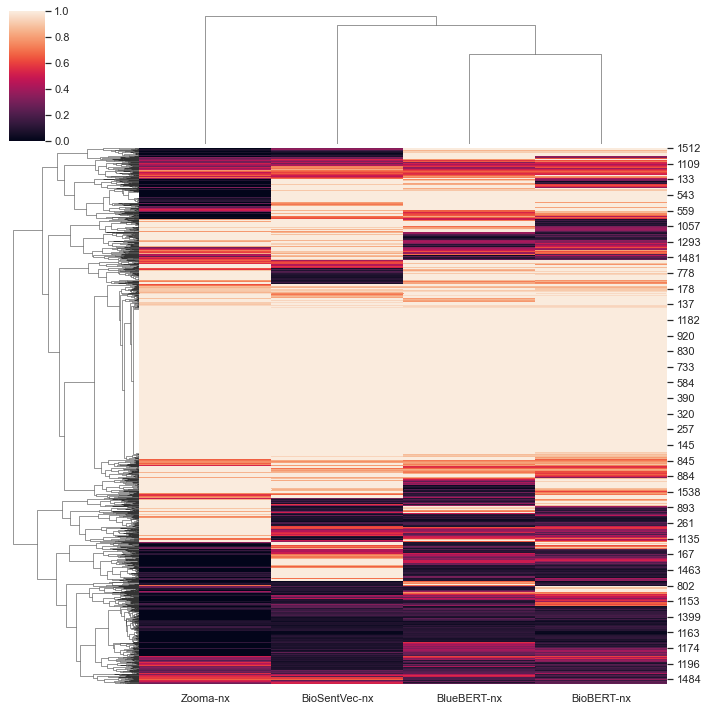

In [26]:
# clustermap
nx_list = ['BioSentVec-nx','BlueBERT-nx','BioBERT-nx','Zooma-nx']
g = sns.clustermap(ebi_df_merge[nx_list])
g.savefig('output/clustermap.pdf')

In [ ]:
# pandas profiling
profile = ProfileReport(ebi_df_merge, title="Pandas Profiling Report")
#profile.to_widgets()
profile.to_notebook_iframe()

  index  BioSentVec-nx  BlueBERT-nx  BioBERT-nx  Zooma-nx
0  mean       0.675618     0.643462    0.653842  0.628119
1   std       0.387670     0.369146    0.363146  0.416581
2   min       0.011628     0.016807    0.018182  0.000000
3   25%       0.219807     0.253571    0.285714  0.125000
4   50%       0.928571     0.777778    0.777778  0.866667
5   75%       1.000000     1.000000    1.000000  1.000000
6   max       1.000000     1.000000    1.000000  1.000000


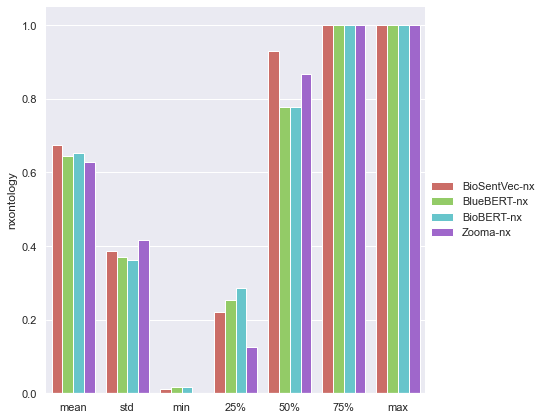

In [67]:
# general metrics
describe_df = ebi_df_merge[nx_list].describe()
describe_df.drop(['count'],inplace=True)
describe_df.reset_index(inplace=True)
print(describe_df)
describe_df_melt = pd.melt(describe_df, id_vars = ['index'])

g = sns.catplot(
    data=describe_df_melt, kind="bar",
    x="index", y="value", hue="variable",
     palette=pallete, height=6
)
g.despine(left=True)
g.set_axis_labels("", "nxontology")
g.legend.set_title("")
g.savefig('output/nx-describe.pdf')